In [1]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
class V_Autoencoder():
    def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        ):
        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)



    def _build(self):
        

        # encoder

        encoder_input = Input(shape=self.input_dim)
        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters=self.encoder_conv_filters[i],
                kernel_size=self.encoder_conv_kernel_size[i],
                strides=self.encoder_conv_strides[i],
                padding='same'
            )
            x = conv_layer(x)
            x = BatchNormalization()(x)
            x = LeakyReLU()(x)
            x = Dropout(rate=0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)

        # VAE

        self.mu = Dense(units =self.z_dim)(x)
        self.log_var = Dense(self.z_dim)(x)
        
        encoder_ouput = Lambda(self.sampling)([self.mu,self.log_var])
        self.encoder = Model(encoder_input,encoder_ouput)


        ### Decoder

        decoder_input = Input(shape=(self.z_dim,))

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters=self.decoder_conv_t_filters[i],
                kernel_size=self.decoder_conv_t_kernel_size[i],
                strides=self.decoder_conv_t_strides[i],
                padding="same"

            )
            x = conv_t_layer(x)
            x = BatchNormalization()(x)
            x = LeakyReLU()(x)
            x = Dropout(rate=0.25)(x)

        decoder_output = x
        self.decoder = Model(decoder_input,decoder_output)

        ## Connect Encoder and Decoder ##

        model_input = encoder_input
        model_output = self.decoder(encoder_ouput)
        self.model = Model(model_input,model_output)

        ## Optimizer and loss Function ##

        optimizer = Adam(lr =0.0005)

        ## compile
        self.model.compile(optimizer =optimizer,
        loss = self.vae_loss,
        metrics=[self.vae_r_loss, self.vae_kl_loss]
        )


### loss, Sampling Function ###
    def r_loss(self, y_true, y_pred):
        return K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])

    def vae_r_loss(self, y_true, y_pred):
        return K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])

    def vae_kl_loss(self, y_true, y_pred):
        return -0.5 * K.sum(1+self.log_var - K.square(self.mu) - K.exp(self.log_var), axis=1)

    def vae_loss(self, y_true, y_pred):
        r_loss = self.vae_r_loss(y_true, y_pred)
        kl_loss = self.vae_kl_loss(y_true, y_pred)
        return 10000*r_loss + kl_loss

    def sampling(self, args):
        mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mu), mean=0, stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon

In [3]:
def input_celeba_data():
    DATA_PATH = '/home/sjo506/Gan_practice/test/celeba'
    BATCH_SIZE = 128
    data_gen = ImageDataGenerator(rescale=1./255) 
    data_flow = data_gen.flow_from_directory(DATA_PATH,
    target_size = [128,128],
    batch_size = BATCH_SIZE,
    shuffle= True,
    class_mode='input',
    subset='training'
        )
    return data_flow


In [4]:
data_train = input_celeba_data()
VAE = V_Autoencoder(
        input_dim =(128,128,3)
        , encoder_conv_filters = [32,64,64,64]
        , encoder_conv_kernel_size =[3,3,3,3]
        , encoder_conv_strides = [2,2,2,2]
        , decoder_conv_t_filters = [64,64,32,3]
        , decoder_conv_t_kernel_size =[3,3,3,3]
        , decoder_conv_t_strides =[2,2,2,2]
        , z_dim =200
)
VAE._build()

Found 202599 images belonging to 1 classes.


In [5]:
VAE.model.fit_generator(
    data_train,
    validation_data = data_train,
    shuffle = True,
    epochs =6
)


Epoch 1/6
1583/1583 [==============================] - 3711s 2s/step - loss: 1694.4358 - vae_r_loss: 0.1618 - vae_kl_loss: 76.3294 - val_loss: 528.0496 - val_vae_r_loss: 0.0486 - val_vae_kl_loss: 53.4980
Epoch 2/6
1583/1583 [==============================] - 3705s 2s/step - loss: 962.1548 - vae_r_loss: 0.0910 - vae_kl_loss: 52.0932 - val_loss: 386.0816 - val_vae_r_loss: 0.0355 - val_vae_kl_loss: 46.3482
Epoch 3/6
1583/1583 [==============================] - 3711s 2s/step - loss: 904.8027 - vae_r_loss: 0.0857 - vae_kl_loss: 48.1808 - val_loss: 371.6060 - val_vae_r_loss: 0.0340 - val_vae_kl_loss: 46.0524
Epoch 4/6
1583/1583 [==============================] - 3710s 2s/step - loss: 898.5174 - vae_r_loss: 0.0851 - vae_kl_loss: 47.7804 - val_loss: 385.9536 - val_vae_r_loss: 0.0323 - val_vae_kl_loss: 47.6312
Epoch 5/6
1583/1583 [==============================] - 3705s 2s/step - loss: 895.1982 - vae_r_loss: 0.0848 - vae_kl_loss: 47.6716 - val_loss: 383.6795 - val_vae_r_loss: 0.0340 - val_vae_k

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

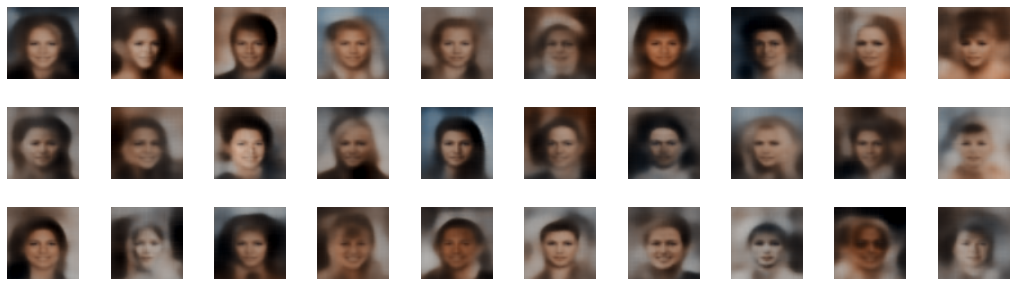

In [6]:
n_to_show =30
znew = np.random.normal(size = (n_to_show, VAE.z_dim))

reconst = VAE.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4,wspace =0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3,10,i+1)
    ax.imshow(reconst[i,:,:,:])
    ax.axis('off')
plt.show()